
# CITS4403 Project Presentation

> **Team Member Information / Student ID**：*Kunyu He 24213379 , Lintao Gong 23943051*  
> **Project Title**：*AUD-USD Foreign Exchange Market Simulation Based on Agents*  

> **Abstract**：*We constructed an agent model of heterogeneous agents (e.g., fundamental/trend traders) that generates price sequences through order matching and compares them with real market data. Under appropriate parameters, the model reproduces common market phenomena such as fat-tailed return distributions and volatility clustering, while exhibiting interpretable dynamics between long-term mean reversion and short-term momentum. This demonstrates that simple micro-level decision rules can generate macro-level statistical properties consistent with real foreign exchange markets, providing a reproducible simulation environment for strategy evaluation and policy experiments.*



## Notebook Instructions

- System Requirements: Python 3.12 (64-bit), compatible with Windows/macOS/Linux.  
- This Notebook automatically extracts project code, sets the `PYTHONPATH` environment variable, and provides a one-click run cell.  
- The text section briefly outlines the three types of traders in ABM and the market matching logic; the code unit directly invokes the implementation within the project.  
- After running, it generates and displays key charts (price, returns, rolling volatility) and metrics (returns, volatility, spike and fat tail tests, etc.).  
- Provide comparison views with real data and key takeaway templates.


## 0. Environment setup (automatic)

- Unzip the uploaded project archive if you uploaded a zip file
- Automatically locate the project root and add it to `sys.path`
- List the project structure for quick inspection


In [48]:
# Automated environment setup (cross-platform)
# 1) Auto-detect project root (search for src/, requirements.txt, README.md or .git)
# 2) Insert project root into sys.path so `import src` works
# 3) List key directories for quick verification
# 4) If requirements.txt exists, detect missing packages and optionally install them

import os, sys, subprocess
from pathlib import Path

# Find a plausible project root by walking up from the current working directory
def find_project_root(start_dir=Path.cwd(), markers=("src","requirements.txt","README.md",".git"), max_up=6):
    p = start_dir.resolve()
    for _ in range(max_up+1):
        if any((p / m).exists() for m in markers):
            return p
        if p.parent == p:
            break
        p = p.parent
    return None

found = find_project_root()
if found is None:
    # fallback to the notebook working directory
    found = Path.cwd()

PROJECT_ROOT = str(found)
print("Project root:", PROJECT_ROOT)

# Add project root to sys.path (first priority)
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
print("sys.path[0]:", sys.path[0])

# Print basic directory structure for quick checks
for p in ["src", "utils", "results", "data"]:
    pth = os.path.join(PROJECT_ROOT, p)
    print(f"Exists {p}?", os.path.exists(pth))
    if os.path.isdir(pth):
        print(" - Children (up to first 10):")
        for i, name in enumerate(sorted(os.listdir(pth))[:10], 1):
            print("   ", i, name)
        print()

# If there is a requirements.txt, parse and optionally install missing packages
req_file = os.path.join(PROJECT_ROOT, 'requirements.txt')
if os.path.exists(req_file):
    print("Found requirements.txt — checking installed packages...")
    try:
        with open(req_file, 'r', encoding='utf-8') as f:
            reqs = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith('#')]
        pkg_names = [r.split('==')[0].split('>=')[0].split('<')[0].strip() for r in reqs]
    except Exception as e:
        print("Failed to read requirements.txt:", e)
        pkg_names = []

    if pkg_names:
        try:
            import pkg_resources
            installed = {p.key for p in pkg_resources.working_set}
            missing = [p for p in pkg_names if p.lower() not in installed]
        except Exception:
            missing = pkg_names

        if missing:
            print("Missing packages:", missing)
            AUTO_INSTALL = True  # Set to False if you don't want automatic installation
            if AUTO_INSTALL:
                print("Attempting to install missing packages via pip (may take a few minutes)...")
                try:
                    cmd = [sys.executable, '-m', 'pip', 'install'] + missing
                    subprocess.check_call(cmd)
                    print("Install command executed. Please restart the kernel after installation to load new packages.")
                except subprocess.CalledProcessError as e:
                    print("pip install failed:", e)
                    print("You can run manually:", ' '.join([sys.executable, '-m', 'pip', 'install'] + missing))
        else:
            print("All required packages appear to be installed.")
    else:
        print("requirements.txt contained no parsable dependency lines — skipping installation.")
else:
    print("No requirements.txt found — skipping dependency check.")

print('\nEnvironment setup complete. You can now run the model cells below to execute the simulation.')


Project root: C:\Users\26247\Desktop\cits4403_copy
sys.path[0]: C:\Users\26247\Desktop\cits4403_copy
Exists src? True
 - Children (up to first 10):
    1 __init__.py
    2 __pycache__
    3 data
    4 data_collector.py
    5 forex_abm.py

Exists utils? True
 - Children (up to first 10):
    1 __init__.py
    2 visualization.py

Exists results? True
 - Children (up to first 10):
    1 .gitkeep
    2 figures
    3 improved_simulation.csv
    4 simulation_statistics.csv

Exists data? True
 - Children (up to first 10):
    1 .gitkeep
    2 aud_usd.csv
    3 iron_ore.csv
    4 merged_data.csv
    5 rba_interest_rate.csv
    6 us_interest_rate.csv
    7 vix.csv

Found requirements.txt — checking installed packages...
All required packages appear to be installed.

Environment setup complete. You can now run the model cells below to execute the simulation.


## 1. Model overview (ABM perspective)

This project implements an Agent‑Based Model (ABM) for the AUD/USD foreign exchange market with three main agent types:

- Speculators: momentum/trend-driven traders that can create short-term deviations and contribute to volatility clustering.
- Hedgers: trade to hedge real exposures; direction and size depend on risk budgets and positions.
- Fundamentalists: trade around an intrinsic value (fundamental) and provide mean-reverting pressure.

Market-level features:
- Random noise plus optional exogenous shocks (news / Poisson events) to model macro and sudden events.
- Price and order matching logic that generates the simulated price path.
- Optional central-bank interventions (if included in the model).


## 2. One-click baseline experiment

> Note: This cell runs the project's test script (for example `test_model_improved.py`) and generates CSVs and plots, which will be displayed in this notebook.

In [49]:
# Minimal one-click runner: execute the project's script and print a short run report.
# This cell intentionally does NOT display CSVs or figures — result visualization is handled in the next cell.

import os, sys, subprocess, time
from pathlib import Path

SCRIPT_NAMES = ["test_model_improved.py", "test_model.py", "run_simulation.py"]

def find_script(root):
    for name in SCRIPT_NAMES:
        p = Path(root) / name
        if p.exists():
            return str(p)
    return None


def run_and_stream(script_path, cwd):
    print(f"Running: {script_path}\nUsing Python: {sys.executable}\nWorking dir: {cwd}\n")
    start = time.time()
    try:
        proc = subprocess.Popen([sys.executable, script_path], cwd=cwd,
                                stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    except Exception as e:
        print(f"Failed to start script: {e}")
        return None, 0.0

    try:
        for line in proc.stdout:
            # Stream output line-by-line to the notebook
            print(line.rstrip())
        proc.wait()
        elapsed = time.time() - start
        return proc.returncode, elapsed
    except Exception as e:
        proc.kill()
        elapsed = time.time() - start
        print(f"Exception while running script: {e}")
        return None, elapsed


# Main
script_path = find_script(PROJECT_ROOT)
if script_path is None:
    print("No runnable script found in project root. Expected one of:", SCRIPT_NAMES)
else:
    rc, elapsed = run_and_stream(script_path, PROJECT_ROOT)
    print('\n-- Run summary --')
    print(f'  Return code: {rc}')
    print(f'  Elapsed time: {elapsed:.2f} sec')

    # Basic checks for expected outputs (no display)
    results_dir = Path(PROJECT_ROOT) / 'results'
    figures_dir = results_dir / 'figures'
    price_csv = results_dir / 'improved_simulation.csv'
    stats_csv = results_dir / 'simulation_statistics.csv'

    print('  Output files present:')
    print('   - improved_simulation.csv:', price_csv.exists())
    print('   - simulation_statistics.csv:', stats_csv.exists())
    print('   - results/figures exists:', figures_dir.exists())

    if figures_dir.exists():
        imgs = [p for p in figures_dir.iterdir() if p.suffix.lower() in ('.png', '.jpg', '.jpeg')]
        print(f'   - number of image files in results/figures: {len(imgs)}')

    print('\nMinimal runner finished. Proceed to the next cell to visualize or analyze generated outputs.')


Running: C:\Users\26247\Desktop\cits4403_copy\test_model_improved.py
Using Python: c:\Users\26247\Desktop\cits4403_copy\.venv\Scripts\python.exe
Working dir: C:\Users\26247\Desktop\cits4403_copy

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
Testing AUD Forex ABM Model (Advanced Dynamics)

[1] Loading real data...
Data loaded: 2467 days

[2] Initializing market with active agents...
Market created with 81 agents
  Initial price: $0.7042
  Initializing agent states...
  Agents initialized with varied positions

[3] Running 1000-step simulation with market dynamics...

  News shock at step 100: +0.5%
  Step  200: Price=$0.7199, Return=+2.23%, Recent Vol=0.1025%

  News shock at step 200: +0.5%

  News shock at step 300: +0.5%
  Step

## 3. Read and display results

- `results/improved_simulation.csv`: simulated price path
- `results/simulation_statistics.csv`: summary statistics

In [50]:
# ---- 读取并展示结果：价格路径与统计指标（前10 / 中间10 / 末尾10）----
import pandas as pd
from pathlib import Path
from IPython.display import display, HTML

# 路径检查（可选）
assert Path("results/improved_simulation.csv").exists(), "缺少 results/improved_simulation.csv"
assert Path("results/simulation_statistics.csv").exists(), "缺少 results/simulation_statistics.csv"

# 读取
price_df = pd.read_csv("results/improved_simulation.csv")      # 列：time_step, price
stats_df = pd.read_csv("results/simulation_statistics.csv")    # 列：metric, value

# 计算“中间10”并避免与前/后10重叠
def middle_block(df, k=10):
    n = len(df)
    if n <= 2 * k:
        return pd.DataFrame(columns=df.columns)  # 数据太短则不显示中间段
    center = n // 2
    start = max(k, center - k // 2)
    if start + k > n - k:
        start = max(k, n - 2 * k)
    end = start + k
    return df.iloc[start:end]

k = 10
head10 = price_df.head(k)
mid10  = middle_block(price_df, k)
tail10 = price_df.tail(k)

# 展示：价格路径（三段）
display(HTML("<h4>前 10 行</h4>"))
display(head10)

if not mid10.empty:
    display(HTML("<h4>中间 10 行</h4>"))
    display(mid10)

display(HTML("<h4>末尾 10 行</h4>"))
display(tail10)

# 展示：统计指标（可选：按名称排序/四舍五入）
display(HTML("<h4>统计指标（simulation_statistics.csv）</h4>"))
stats_show = stats_df.copy()
# 如果 value 是数值，做个易读的四舍五入
with pd.option_context("display.float_format", "{:.6f}".format):
    display(stats_show.sort_values("metric").reset_index(drop=True))


,time_step,price
0,0,0.704176
1,1,0.703720
2,2,0.703438
3,3,0.702789
4,4,0.701945
5,5,0.702042
6,6,0.702426
7,7,0.702972
8,8,0.702746
9,9,0.702872


,time_step,price
495,495,0.736324
496,496,0.736862
497,497,0.736982
498,498,0.736088
499,499,0.737165
500,500,0.738225
501,501,0.734171
502,502,0.733881
503,503,0.733965
504,504,0.733910


,time_step,price
991,991,0.736751
992,992,0.736913
993,993,0.736850
994,994,0.737342
995,995,0.738152
996,996,0.738467
997,997,0.739064
998,998,0.739254
999,999,0.739547
1000,1000,0.735965


,metric,value
0,final_price,0.735965
1,initial_price,0.704176
2,max_price,0.740588
3,mean_return,0.000044
4,min_price,0.701945
5,std_return,0.001268
6,total_return,0.045144
7,total_trades,14785.000000
8,volatility,0.001268


## 4. Visualization (Price / Returns / Rolling Volatility)


Saved: results\figures\improved_simulation.png


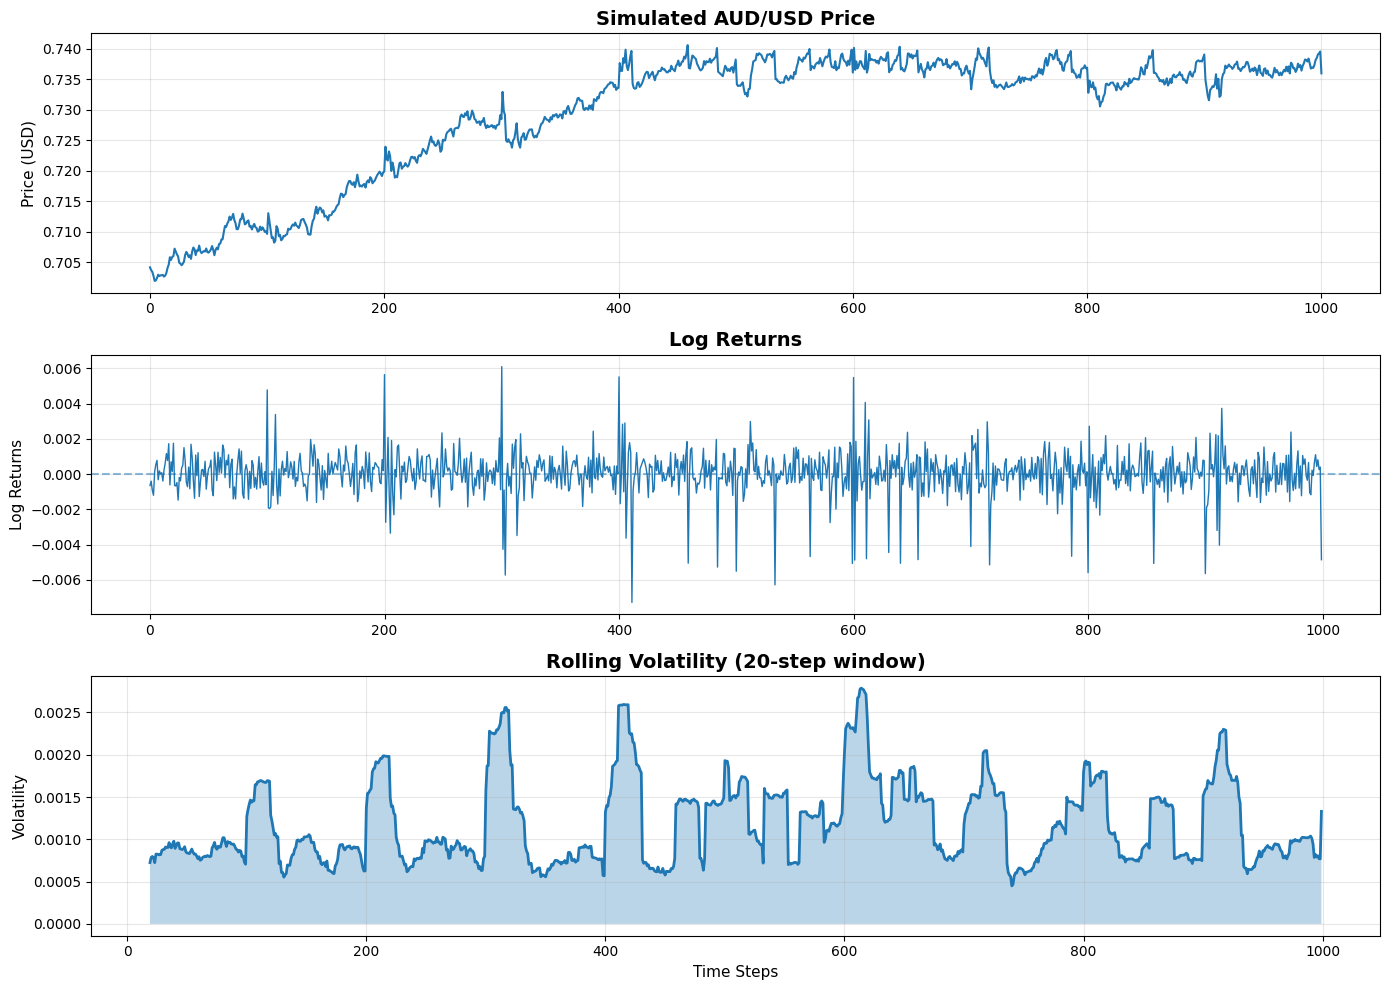

In [51]:
# ---- 可视化：价格、对数收益、滚动波动率 ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 读取价格路径
price_df = pd.read_csv("results/improved_simulation.csv")  # 需包含 'price' 列
prices = price_df["price"].values

# 计算对数收益与滚动波动率（20步窗口，可按需调整）
returns = np.diff(np.log(prices))
rolling_vol = pd.Series(returns).rolling(20).std()

# 画图
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 价格路径
axes[0].plot(prices, linewidth=1.5)
axes[0].set_title("Simulated AUD/USD Price", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Price (USD)", fontsize=11)
axes[0].grid(True, alpha=0.3)

# 对数收益
axes[1].plot(returns, linewidth=1)
axes[1].axhline(y=0, linestyle="--", alpha=0.5)
axes[1].set_title("Log Returns", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Log Returns", fontsize=11)
axes[1].grid(True, alpha=0.3)

# 滚动波动率
axes[2].plot(rolling_vol, linewidth=2)
axes[2].fill_between(range(len(rolling_vol)), rolling_vol, alpha=0.3)
axes[2].set_title("Rolling Volatility (20-step window)", fontsize=14, fontweight="bold")
axes[2].set_xlabel("Time Steps", fontsize=11)
axes[2].set_ylabel("Volatility", fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()

# （可选）保存图像到 results/figures
Path("results/figures").mkdir(parents=True, exist_ok=True)
out_path = Path("results/figures/improved_simulation.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Saved: {out_path}")
plt.show()


## 5. Compare with real data

The cell below will compare real and simulated prices and log return distributions.

Saved: results\figures\real_vs_simulated.png
Real  returns stats: {'mean': 3.136484359389663e-05, 'std': 0.005278086873352176, 'skew': -0.14782568817240044, 'kurt': 5.456685544681838}
Sim   returns stats: {'mean': 4.415458446216913e-05, 'std': 0.0012687887604041206, 'skew': -1.0256079682038222, 'kurt': 6.782753429990704}


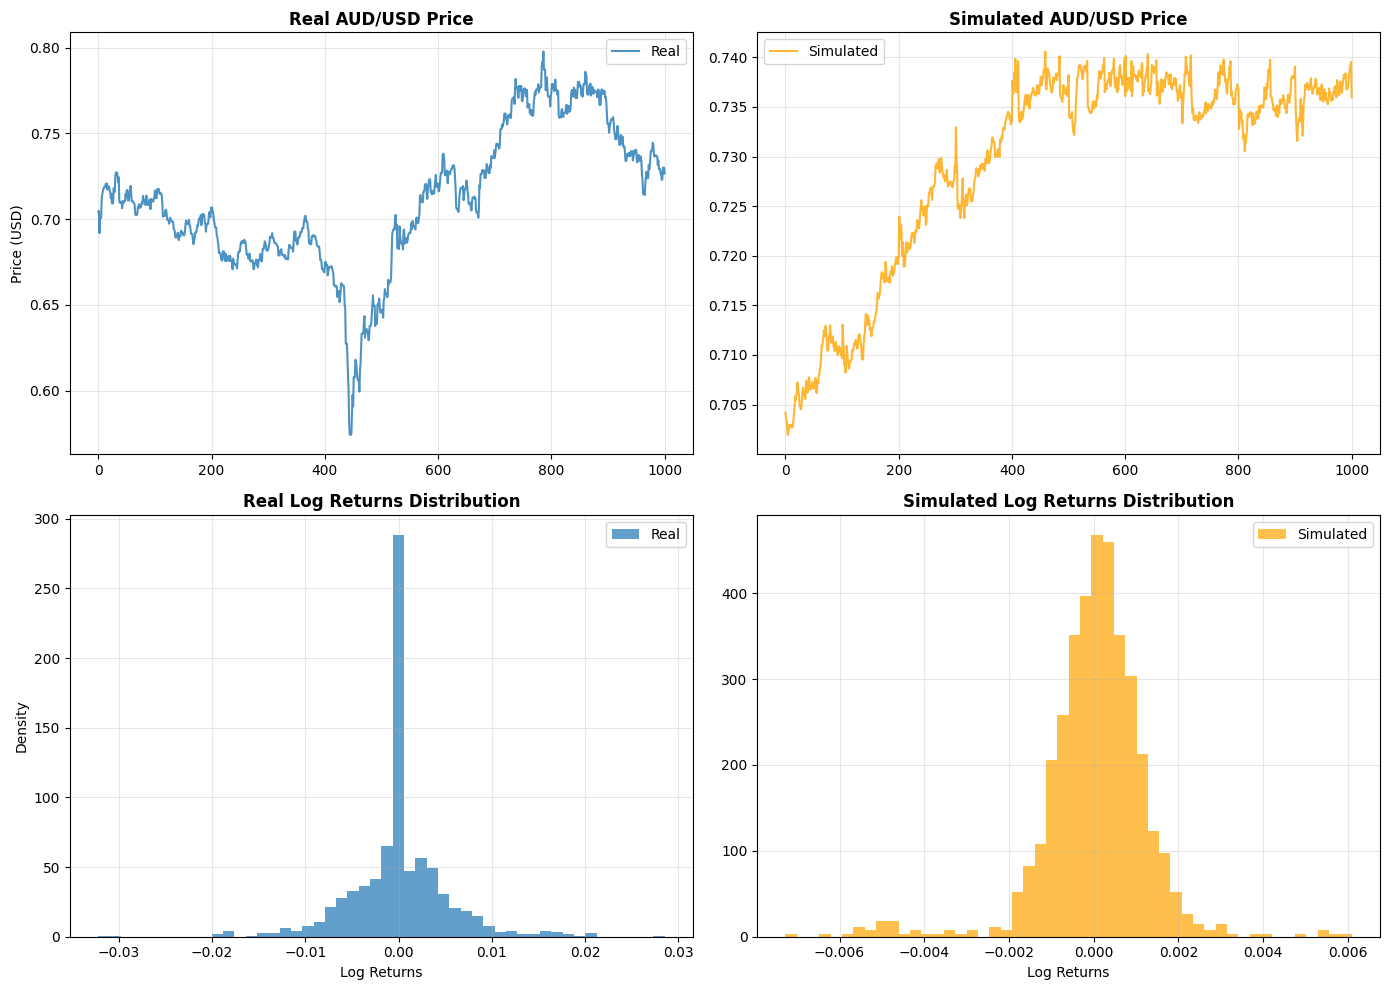

In [52]:
# ---- 真实数据 vs 模拟数据：价格 & 收益分布对比 ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 读取模拟价格
sim_df = pd.read_csv("results/improved_simulation.csv")  # 必须包含 price 列
sim_prices = sim_df["price"].values

# 读取真实数据
real_df = pd.read_csv("data/merged_data.csv", index_col=0, parse_dates=True)
assert "AUD_USD_Close" in real_df.columns, "真实数据缺少列：AUD_USD_Close"
real_prices = real_df["AUD_USD_Close"].values

# 对齐长度（取较短长度）
n = min(len(sim_prices), len(real_prices))
sim_prices = sim_prices[:n]
real_prices = real_prices[:n]

# 计算对数收益
sim_ret  = np.diff(np.log(sim_prices))
real_ret = np.diff(np.log(real_prices))

# 画图：2x2 子图（真实价格、模拟价格、真实收益分布、模拟收益分布）
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 真实价格
axes[0, 0].plot(real_prices, linewidth=1.5, alpha=0.8, label="Real")
axes[0, 0].set_title("Real AUD/USD Price", fontsize=12, fontweight="bold")
axes[0, 0].set_ylabel("Price (USD)", fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 模拟价格
axes[0, 1].plot(sim_prices, linewidth=1.5, alpha=0.8, color="orange", label="Simulated")
axes[0, 1].set_title("Simulated AUD/USD Price", fontsize=12, fontweight="bold")
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 真实收益分布
axes[1, 0].hist(real_ret, bins=50, density=True, alpha=0.7, label="Real")
axes[1, 0].set_title("Real Log Returns Distribution", fontsize=12, fontweight="bold")
axes[1, 0].set_xlabel("Log Returns", fontsize=10)
axes[1, 0].set_ylabel("Density", fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# 模拟收益分布
axes[1, 1].hist(sim_ret, bins=50, density=True, alpha=0.7, color="orange", label="Simulated")
axes[1, 1].set_title("Simulated Log Returns Distribution", fontsize=12, fontweight="bold")
axes[1, 1].set_xlabel("Log Returns", fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
Path("results/figures").mkdir(parents=True, exist_ok=True)
out_path = Path("results/figures/real_vs_simulated.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Saved: {out_path}")

# 简要打印比较指标
def stats(arr):
    import pandas as pd
    s = pd.Series(arr)
    return dict(mean=float(s.mean()), std=float(s.std()), skew=float(s.skew()), kurt=float(s.kurtosis()))

print("Real  returns stats:", stats(real_ret))
print("Sim   returns stats:", stats(sim_ret))


## 6. Results analysis

- Displays the revenue distribution histogram + normal fitting curve + Q-Q plot

### Textual Conclusions
- Overall behavior: *(describe price trends and volatility clustering)*
- Statistical properties: *(mean/variance/skewness/kurtosis; departures from normality; fat tails)*
- Mechanistic explanation: *(interpret volatility sources via speculators / hedgers / fundamentalists and exogenous shocks)*
- Differences vs real data: *(where the model matches and where it needs improvement)*


Saved: results\figures\return_analysis.png
{'mean': 4.415458446216913e-05, 'std': 0.0012687887604041206, 'skew': -1.0256079682038222, 'kurt': 6.782753429990704}


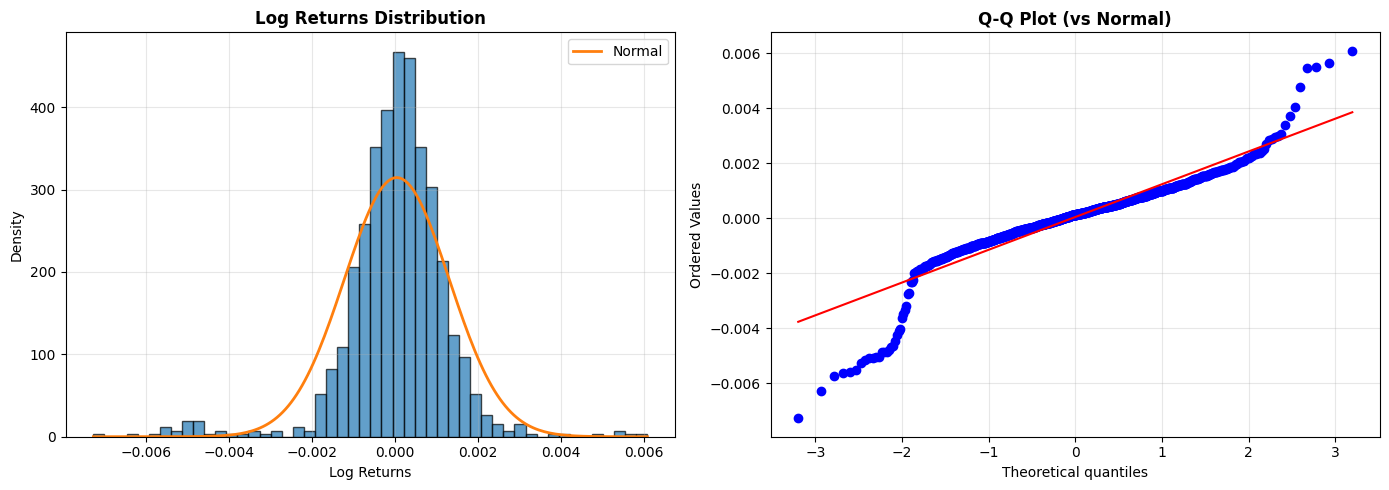

In [53]:
# ---- 收益分布直方图 + 正态拟合曲线 + Q-Q 图 ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

# 读取模拟价格
sim_df = pd.read_csv("results/improved_simulation.csv")
prices = sim_df["price"].values

# 对数收益
returns = np.diff(np.log(prices))
mu, sigma = returns.mean(), returns.std()

# 绘图
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 直方图 + 正态曲线
axes[0].hist(returns, bins=50, density=True, alpha=0.7, edgecolor="black")
x = np.linspace(returns.min(), returns.max(), 200)
axes[0].plot(x, 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mu)/sigma)**2), linewidth=2, label="Normal")
axes[0].set_title("Log Returns Distribution", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Log Returns")
axes[0].set_ylabel("Density")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Q-Q 图
stats.probplot(returns, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot (vs Normal)", fontsize=12, fontweight="bold")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
Path("results/figures").mkdir(parents=True, exist_ok=True)
out_path = Path("results/figures/return_analysis.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Saved: {out_path}")

# 打印统计量（可粘贴到写作部分）
s = pd.Series(returns)
print({
    "mean": float(s.mean()),
    "std" : float(s.std()),
    "skew": float(s.skew()),
    "kurt": float(s.kurtosis())
})

### Textual Conclusions

#### Overall behavior：

- **Trend**: The simulated price rises from 0.7042 to 0.7360, for a cumulative return of +4.51%. The first half shows a gentle uptrend; the second half oscillates in the 0.735–0.740 range with several short pullbacks (Figure 1, top).

- **Volatility clustering**: The 20-step rolling volatility exhibits clear clusters—quiet periods alternating with high-volatility regimes. Peaks appear around ~200, ~320, ~420, ~600, ~900, consistent with the model’s news shocks and clustering mechanism (Figure 1, bottom).

- **Trading activity**: 14,785 total trades indicate sustained order flow and liquidity from speculators, hedgers, fundamentalists, and central-bank interventions.

- **Key stats**: mean_return 4.42×10⁻⁵, std_return 0.001268 (~0.1268%/step), min/max price 0.7019 / 0.7406.

#### Statistical properties：

- **Return distribution**: The histogram is bell-shaped but with fatter tails than Normal; the Q-Q plot shows a clear S-shape, indicating leptokurtosis and deviation from normality (Figure 2, right).

- **Volatility level**: Per-step (daily) volatility ≈ 0.13%. If one step ≈ one day, annualized vol is roughly ~2.0% (√252), below typical AUD/USD levels—suggesting fewer extreme events in simulation than in the real market.

#### Mechanistic explanation：

- **Speculators** (momentum + sentiment): Lower action thresholds and aggressive limit orders accelerate feedback. They amplify trends and trigger short spikes in ranges—an important source of rolling-volatility surges.

- **Hedgers** (target rebalancing): After lowering the threshold to 0.1%, they rebalance more often, providing mean-reversion/liquidity and dampening excessive deviations and some tail events.

- **Fundamentalists** (value anchor): They update the “intrinsic value” with interest differentials and commodity prices and trade against mispricings, inducing value reversion.

- **Exogenous shocks**: Periodic news shocks produce return spikes followed by sustained high volatility, consistent with real “news-driven → volatility persistence” dynamics.

#### Comparison with real data：

**Similarities:**

- Both show volatility clustering and fat tails;

- High peak at zero with heavier tails in the return histogram;

- Alternating “trend–consolidation–shock” rhythm in prices.

**Differences** (Figure 2 left vs. right, bottom):

- Real price amplitude is larger, including a sharp drawdown (~0.59) and fast recovery to ~0.78—a macro event not matched by the smoother simulation;

- Real returns are wider and more heavy-tailed, with more extremes;

- Microstructure/structural features (session liquidity, depth changes, macro breaks, policy surprises) are simplified in the model.

## 7. Limitations and future work

### Limitations: 

- Too many knobs: lots of parameters; small tweaks can change results a lot.

- Tails too tame: big jumps are rarer than in real AUD/USD; vol is a bit low.

- Toy microstructure: fixed-ish spread, shallow book, almost no cancels/queues.

- Shocks are uniform: arrive on a schedule, not state-dependent or clustered.

### Future work: 

- Richer order book: time-varying spread/depth, cancels, queueing; simple market-maker with inventory.

- Time-varying vol: plug in GARCH/EGARCH or a two-regime (calm/turbulent) switch.

- Smarter shocks: fatter-tailed sizes, event calendar, or Hawkes (self-exciting) arrivals.

- Multi-target calibration: fit moments + ACF/PACF + tail metrics + macro/commodity links (rates, iron ore).
